# Data preparation

## Introduction 

This notebook will replicate this program from Jason Brownlee's Machine Learning Mastery post given [here](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/). The aim is to get an understanding of how to work with simple .jpg files in making machine learning algorithms. The task in this post is to take an image as input and predict whether that image contains one of seventeen land types. The inputs are (128 X 128) images of Amazon rainforest area. The post makes a convolutional neural net to make predictions.

The first set of code prepares the data. This code is meant to be run only once to load the images, convert them into numerical arrays, compress them, and store them in a format called .npz. Because it is meant to be run only once, currently there are no function calls for this code. The second part of the code is the model set-up and training. Everything is the same as in the blog post except for we have removed one hidden layer from the neural network just to speed up training to get the process correct.

## Housekeeping

The block below imports the packages needed for preparing the data. The imports all get used in the code. **Pandas** is needed to read .csv files. **Numpy** provides fast numerical array operations. **Keras** is the deep learning framework we are using. **OS** allows us to perform actions like listing all the files in a particular folder. **Matplotlib** lets us make model evaluation plots.

In [7]:
import pandas as pd
import numpy as np
import keras
import os

from matplotlib import pyplot 
from matplotlib.image import imread

The code block below sets the size of the plot. The default plot size in notebooks is very big. This takes care of that by making the plots smaller and easier to see. This makes sense here since we are going to be making only simple plots like looking at satellite imagery or training/test error plots which don't need to be very huge.

In [8]:
# Set plot size
pyplot.rcParams['figure.figsize'] = [15, 10]

## Set the parameters

We are using a Python library called **papermill** to run the notebook from the command line. **Papermill** looks for a cell in the notebook with the tag **parameters** like below and then either uses the values specified in this cell as the parameter values or over-rides these values with those that are supplied using the command line. 

In [9]:
# This sets whether we want parameters or not
train = False

# We want detailed output at the end of every epoch
verbose = 1

# Epochs
epochs = 1

# Batch size
batch_size = 128

# Learning rate
lr = 0.05

# Momentum
momentum = 0.9

# Shape of expected inputs output
in_shape=(32, 32, 3)

# Shape of expected output
out_shape=17

## Look at the images

We start off by writing a function which plots 9 images that are located in the image folder. We want to plot the 9 purely for reasons of convenience. We will otherwise have to write formatting code for the subplots which is not worth the time. First we write a function which samples 9 images from the data-set. It then sends a list of the 9 sampled file names to the second function. 

This function plots the raw pixel data of the .jpg images in the notebook. The **imread** function from matplotlib loads the image. The **imshow** function in pyplot creates the plot and adds it to the sub-plot. The entire sub-plot is shown once the loop exits.

In [10]:
def get_sample(folder = 'train-jpg'):
    '''
    Input: File path
    Output: Sample of 9 images to plot from training set
    '''
    # List all files in dir
    files = [f for f in os.listdir(folder)]
    # Select nine files randomly
    random_files = np.random.choice(files, size = 9, replace = False)
    # Return
    return(random_files)

In [11]:
def plot_first_nine(sample, folder = 'train-jpg/'):
    '''
    Input: File path to training data.
    Output: Plot of first 9 images in training data.
    
    We plot 9 images because otherwise we will have to
    write formatting code for the sub-plot which is not
    worth the time.
    '''
    for i in range(9):
        # pyplot.subplot takes 3 digit code 
        # The first number is the number of rows
        # The second number is the number of columns
        # The third number is the position in the subplot 
        pyplot.subplot(340 + 1 + i)
        # Load image pixels
        image = imread(folder + sample[i])
        # Plot raw pixel data
        pyplot.imshow(image)
    # Show the figure
    pyplot.show()
    # End the function
    return

Now we can call the functions from above to actually take a look at the output. There will be a different random sample taken every time. **Note that these function calls are for testing and demonstration only**.

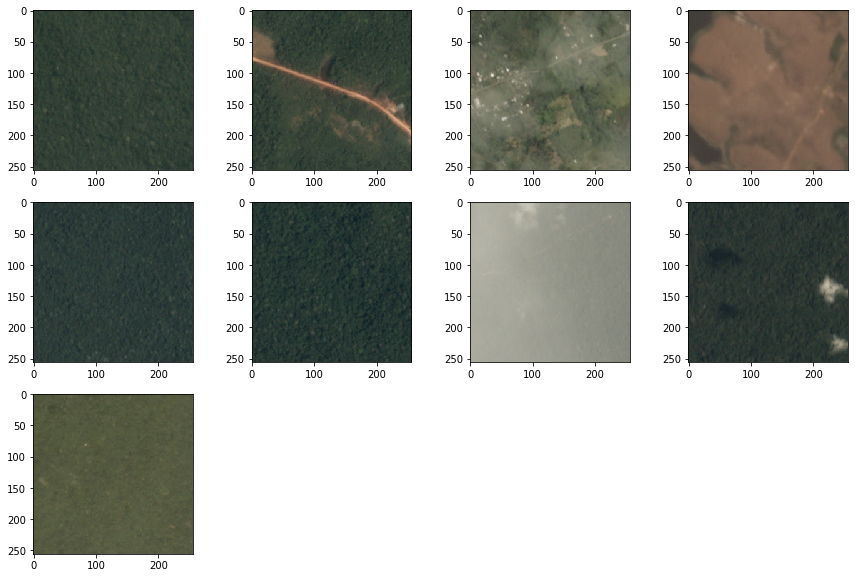

In [12]:
if not train: 

    # Create a sample
    sample = get_sample()


    # Plot the first nine images
    plot_first_nine(sample)

## Creating a mapping data-frame

**train_v2.csv** is a .csv file that has two columns. The first column is the name of the image. The second column is a string that contains all the labels that apply to that image. An example first column observation is **'train_0.jpg'.** An example second column observation is **'haze forest cloud'.** The function below takes the file name as input and returns a pandas data-frame version of this file for the code to use later.

In [13]:
def load_mapping_data(file_name = 'train_v2.csv'):
    '''
    Input: mapping file name
    Output: mapping file data-frame
    '''
    mapping_df = pd.read_csv(file_name)
    
    return(mapping_df)

In [14]:
if not train:

    # Call the function and check out the output
    mapping_df = load_mapping_data()

The data-frame has approximately 40000 rows and 2 columns.

In [15]:
if not train:

    # Print out the shape of the mapping frame
    pd.DataFrame(list(mapping_df.shape), index = ['Rows', 'Columns'], columns = [''])

We print the first few rows of this data-frame just to get an idea of what everything looks like. These are given below. We can tell from this output that this is a **multi-label classification** problem and not a **multi-class classification problem.**

In [16]:
if not train:

    # Print out the first few rows
    mapping_df.head()

## Creating tag mapping

The labels are given in the form of strings. We need to convert them into numbers because our eventual machine learning model will operate on numerical values. The function below takes the mapping data-frame and first gets the unique labels that occur in the data-frame. It then creates two dictionaries. The first dictionary relates string labels to integer values and the second dictionary goes the other way around and relates integer values to labels. These dictionaries are then returned for the code to use.

In [17]:
def create_tag_mapping(mapping_df):
    '''
    Input: mapping data-frame
    Output: Dictionary mapping labels to integers.
    '''
    # Initialize labels
    # Labels is a set so calling update will not affect uniqueness
    labels = set()
    
    # Loop through the data-frame
    # Split the tag values on spaces
    # Then update the set with the tags
    for i in range(len(mapping_df)):
        tags = mapping_df['tags'][i].split(' ')
        labels.update(tags)
    
    # Turn into a list and sort
    labels = list(labels)
    labels.sort()
    
    # First relate labels to integers
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    
    # Return statement
    return(labels_map, inv_labels_map)

In [18]:
if not train:
    
    # Function call
    labels_map, inv_labels_map = create_tag_mapping(mapping_df)

### Labels: Integers

This is the mapping of labels to integers.

In [19]:
if not train:

    # Print to display output
    print(labels_map)

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


### Integers:Labels

This is the mapping from integers to labels.

In [20]:
if not train:

    # Print to display output
    print(inv_labels_map)

{0: 'agriculture', 1: 'artisinal_mine', 2: 'bare_ground', 3: 'blooming', 4: 'blow_down', 5: 'clear', 6: 'cloudy', 7: 'conventional_mine', 8: 'cultivation', 9: 'habitation', 10: 'haze', 11: 'partly_cloudy', 12: 'primary', 13: 'road', 14: 'selective_logging', 15: 'slash_burn', 16: 'water'}


## Create a mapping dictionary

We have the labels associated with each file in the data-frame but we need these labels to be in the form of a dictionary to use in the deep learning model later. This function takes in the data-frame and then goes through it row by row. For each row it extracts the file name and the tags and puts them in separate variables. It then adds a new entry to a mapping dictionary where the key is the file name and the tag is the list of tags. Note that the split command used below takes the dataframe string entry and splits it on spaces and then finally creates a list from it. This is then returned.

In [21]:
def create_file_mapping(mapping_df):
    '''
    Input: mapping data-frame
    Output: mapping dictionary of filename to tags
    '''
    # Initialize the dictionary
    mapping = dict()
    # Iterate through the data-frame range
    for i in range(len(mapping_df)):
        # Store names and tags
        name, tags = mapping_df['image_name'][i], mapping_df['tags'][i]
        # Put them in the dictionary as name:tag key value pairs
        mapping[name] = tags.split(' ')
    
    # Return mapping
    return mapping

### Mapping in dictionary form

Now we test out the function and display the first two key-value pairs to give an idea of the data format.

In [22]:
if not train:

    # Test function call
    mapping_dict = create_file_mapping(mapping_df)

    # Print to display output
    {k: mapping_dict[k] for k in list(mapping_dict)[:2]}

## One-hot encoding the labels

We need to do one-hot encoding of the labels. This is because there are 17 possible tags. We want to create a vector of 0s and 1s such that an element in the vector takes the value 1 only if the label of that image corresponds to the position of the element. So say that the label of a particular image is 'forest' which has integer value 7. Then in the 17 element vector we want only the 7th element to be 1 and the rest of the element values to be zero. This function takes in tags and the tag to integer mapping and returns the needed encoding.

In [23]:
def one_hot_encode(tags, labels_map):
    '''
    There are 17 elements in tag. 
    We want a 17 element vector of 0s and 1s.
    Each element should be 1 if the corresponding
    category is in the image file and 0 otherwise.
    '''
    # Create empty vector
    encoding = np.zeros(len(labels_map), dtype='uint8')
    # Mark 1 for each tag in the vector
    for tag in tags:
        encoding[labels_map[tag]] = 1
    return encoding

In [24]:
if not train:

    # Test function call
    one_hot_encode(['agriculture', 'clear', 'primary', 'water'], labels_map)

## Compress the dataset

We need to compress the dataset because it may cause local laptop to crash. This function iterates through the folder. For each image it uses the **keras** function **load_img** to load this. Then it converts this to a numerical **numpy array** using the **img_to_array** function which is also from **keras.** Then we retreive the tags from the image. Finally we one-hot encode these tags. Then we append to the pre-created list of **photos** and **targets** respectively. Finally we convert these lists into **numpy arrays** of **unsigned integers**.

In [25]:
def compress_dataset(path, file_mapping, tag_mapping, target_size = (128, 128)):
    '''
    Inputs: 1) Folder: Path to training folder
            2) Images file path: Path to training data images within training folder
            3) File mapping: Mapping of training images to their labels
            4) Tag mapping:  One to one mapping of labels to integers
            5) Target size:  Size that input images should be cropped to
    Output: 1) Training data and labels as numpy arrays of unsigned integers
    
    Why is path separately specified? 
    This is probably to ensure that if images are stored remotely like on Amazon S3 
    then this parameter can be easily changed to get data from there. 
    '''
    # Photos and targets stored here
    photos, targets = list(), list()
    # Enumerate files in the directory
    for filename in os.listdir(folder):
        # Load image
        photo = keras.preprocessing.image.load_img(path + filename, target_size=target_size)
        # Convert to numpy array
        photo = keras.preprocessing.image.img_to_array(photo, dtype='uint8')
        # Get tags
        tags = file_mapping[filename[:-4]]
        # One hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # Store photos 
        photos.append(photo)
        # Store targets
        targets.append(target) 
    # We know color channel values go from 0 to 255 and will not be negative
    # Convert to arrays while making data type unsigned
    # Unsigned integer saves space 
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    
    return(X, y)

## Prepare data

The function below just calls the functions from above to execute the pipeline. Note that the target size default value is 32 X 32 to save space assuming that you will run this notebook on your local machine. There is no function call as of now because this is a one time-task. A file called 'planet-data.npz' which is the compressed version of the data-set is stored in the working directory.

In [26]:
def prep_data(folder = 'train-jpg/', target_size = (32, 32)):    
    '''
    Input: None 
    Output: None 
    Description: 
    This is a function that is run for its side effect.
    It runs the code to take in raw images and return single compressed file.
    '''
    # First take a sample
    sample = get_sample()
    # Plot the first nine images
    plot_first_nine(sample)
    # Create mapping data-frame
    mapping_df = load_mapping_data()
    # Create tag mapping
    labels_map, inv_labels_map = create_tag_mapping(mapping_df)
    # Create file mapping
    mapping = create_file_mapping(mapping_df)
    # Load data-set
    X, y = compress_dataset(folder, mapping, labels_map, target_size)
    # Print X.shape, y.shape
    print(X.shape, y.shape)
    # Save both arrays to one file in compressed format
    np.savez_compressed('planet_data.npz', X, y)
    # End of function
    return

# Benchmark model

In [27]:
# Housekeeping imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras import backend

## Train-test split

First we have to load the compressed data-set we created earlier and split it into training and testing data. The function below does this using the sci-kit model selection module. It prints out the shape of the data-sets as a sanity check.

In [28]:
def load_dataset():
    '''
    Input: N/A
    Output: Planet data split into train and test
    '''
    # Load dataset
    data = np.load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']

    # Separate into train and test datasets
    trainX, testX, trainY, testY = sklearn. \
                                   model_selection. \
                                   train_test_split(X, y, test_size=0.3, random_state=1)
    # Print out shapes as a sanity check
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    
    # Create data generators
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, 
                                       vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
        
    # Return both forms of data-sets
    return(trainX, trainY, testX, testY, train_datagen, test_datagen)

## Custom metric

Keras v2.0.0 currently does not support the F-beta loss function for multi-label classification. The F-beta loss function is a weighted average of precision and recall. Over here we use it only as a metric to measure the performance of the model but not in the actual training. The winning score in the competition is approximately 93%. The function given below is just coding this function manually. 

In [29]:
# Calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    '''
    This function is manually written here.
    This is because this competition uses F-beta score as a metric.
    This metric is no longer supported by Keras as v.2.0.0. There is
    a Kaggle kernel which proposes the function given below as a fix
    for this. Until then we use the function code given in the post
    to measure our model's performance.
    
    Open questions: 
    What is the keras.backend module? 
    What does karas.backend.clip do? 
    What does keras.backend.round do? 
    What does keras.backend.epsilon do? 
    '''
    # Clip predictions
    y_pred = keras.backend.clip(y_pred, 0, 1)
    # Calculate true positives
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    # Calculate false positives
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)), axis=1)
    # Calculate false negatives
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # Calculate precision
    p = tp / (tp + fp + keras.backend.epsilon())
    # Calculate recall
    r = tp / (tp + fn + keras.backend.epsilon())
    # Calculate fbeta, averaged across each class
    bb = beta ** 2
    # F-beta score final calculation
    fbeta_score = keras.backend.mean((1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon()))
    # Return statement
    return(fbeta_score)

## All ones prediction

A standard benchmark to decide whether any machine learning model is useful is if our algorithm can get a better score than if we just blindly predict 1 for each and every image we get. The function below implements this all-1s algorithm and returns the score. If the deep learning model that we create later on can do better than this than it is adding value over and above this.

In [30]:
def benchmark(trainX, trainY, testX, testY):
    '''
    Input: Training and test datasets and labels
    Output: Training and test score if we just always predict ones
    '''
    # Make all one predictions
    train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
    test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])
    
    # Evaluate predictions with sklearn
    train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
    test_score = fbeta_score(testY, test_yhat, 2, average='samples')
    print('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))

    # Evaluate predictions with keras
    train_score = fbeta(keras.backend.variable(trainY), keras.backend.variable(train_yhat))
    test_score = fbeta(keras.backend.variable(testY), keras.backend.variable(test_yhat))
    print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))
    
    # Return the train and test sets for future use
    return(train_score, test_score)

# Baseline convolutional neural net

In [31]:
# Baseline model for the Planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

## Define model

The model below is a convolutional neural network with maximum pooling and same padding. It uses **sigmoid activation** in the output layer and **RELU activation** in the hidden layers. The output of the function is a **keras model object.** We use the **binary cross entropy loss**. We also track the **F-beta score** metric according to the custom function defined above.

In [32]:
def define_model(in_shape=(32, 32, 3), out_shape=17, lr = 0.05, momentum = 0.9, opt = 'Adam'):
    '''
    Input: Input shape and output shape
    Output: Keras model object
    '''
    # Define model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta, keras.metrics.accuracy])
    
    return model

## Create diagnostic plots

The function below creates diagnostic plots for easier checking at the end of training. It plots both the loss function and the F-beta score function for training and test. Example plots can be seen in the repository.

In [33]:
# Import packges
import os
import time

In [34]:
def summarize_diagnostics(history):
    '''
    Input: Keras history project
    Output: Display diagnostic learning curves
    '''
    # Plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    # Plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
    
    # Save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [35]:
def make_tensorboard_directory():
    '''
    Input: N/A
    Output: Tensorboard directory path
    '''
    root_logdir = os.path.join(os.curdir, "my_logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    
    return(os.path.join(root_logdir, run_id))

## Hyperparameter optimization

In [36]:
# We will wrap our model as a Keras Classifier object
# We import the GridSearchCV package
# We import the Keras classifier package
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [37]:
def choose_parameters(X, Y, trainX, trainY, testX, testY, 
                      opt = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], 
                      epochs=1, batch_size = 10):    
    '''
    Input: 1) Training set
           2) Validation set
           3) List of optimizers to try
           4) No. of epochs eash search of the grid will use
           5) Batch size
           
    Output: Best parameters along with accuracy metric
    '''
    
    # Create model
    model = KerasClassifier(build_fn=define_model, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Create the parameter dictionary
    param_grid = dict(opt=opt)
    
    # Prepare iterators
    train_flow = X.flow(trainX, trainY, batch_size=batch_size)
    test_flow = Y.flow(testX, testY, batch_size=batch_size)
    
    # Get the datasets
    train_X, train_Y = train_flow.next()
    
    # Create the grid search instance
    # We use 3 fold cross-validation
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
    grid_result = grid.fit(train_X, train_Y)

    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return

## Train the network 

The code below runs the training algorithm for the neural network. It calls the **load_dataset()** function to create training and testing data-sets. It then specifies to **checkpoint** variables. The first checkpoint variable tells **keras** to save a copy of the latest results and estimates to a file called **my_keras_model.h5**. The next checkpoint **early_stopping_cb** specifies that we want training to stop if there is no improvement seen for a particular no. of batches. The **patience** parameter is set to 10. This means that training will automatically stop if there is no improvement seen for 10 successive batches.

In [38]:
def run_test_harness(train_datagen, test_datagen, epochs = 2, verbose = 1, batch_size = 128, lr = 0.05, 
                     momentum = 0.9, in_shape=(32, 32, 3), out_shape=17):
    '''
    Input: None
    Output: None
    Run the test harness for evaluating a model
    '''    
    # Add checkpoints for regular saving
    checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    
    # Add TensorBoard logging
    tensorboard_cb = keras.callbacks.TensorBoard(make_tensorboard_directory())

    # Prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=batch_size)
    test_it = test_datagen.flow(testX, testY, batch_size=batch_size)
    
    # Define model
    model = define_model(in_shape, out_shape, lr, momentum)
    
    # Fit model
    history = model.fit_generator(train_it, 
                                  steps_per_epoch=len(train_it), 
                                  validation_data=test_it, validation_steps=len(test_it), 
                                  callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb], 
                                  epochs=epochs, 
                                  verbose=1)
    # Evaluate model
    loss, fbeta, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f, accuracy=%.3f' % (loss, fbeta, accuracy))
    
    # Learning curves
    summarize_diagnostics(history)

## Execution

Now we are finally ready to train our model. First we will create the datasets we need for the deep-learning pipeline. Then we will benchmark the model against the all-ones predictions given above. Then we will choose hyper-parameters via grid search. This can be easily substituted with another method like randomized search. Next we will train the model.

In [39]:
# Load dataset
trainX, trainY, testX, testY, train_datagen, test_datagen = load_dataset()
    
# Run benchmark
results = benchmark(trainX, trainY, testX, testY)

# Optimize hyperparameters
choose_parameters(train_datagen, test_datagen, trainX, trainY, testX, testY)

(28335, 32, 32, 3) (28335, 17) (12144, 32, 32, 3) (12144, 17)
All Ones (sklearn): train=0.484, test=0.484
All Ones (keras): train=0.484, test=0.484
Best: 0.784314 using {'opt': 'Adagrad'}
0.000000 (0.000000) with: {'opt': 'SGD'}
0.026144 (0.018486) with: {'opt': 'RMSprop'}
0.784314 (0.027730) with: {'opt': 'Adagrad'}
0.000000 (0.000000) with: {'opt': 'Adadelta'}
0.000000 (0.000000) with: {'opt': 'Adam'}
0.000000 (0.000000) with: {'opt': 'Adamax'}
0.000000 (0.000000) with: {'opt': 'Nadam'}


In [40]:
# Entry point
# Run the test harness to see whether everything is working fine
if train: run_test_harness(train_datagen, test_datagen, 
                           epochs, verbose, batch_size, 
                           lr, momentum, in_shape, 
                           out_shape)